In [1]:
## load required libraries 
import sklearn
from sklearn.preprocessing import LabelEncoder
import pandas as pd 
import numpy as np 
import re

In [2]:
#Load the dataset
df = pd.read_csv("ks-projects-201801.csv",  parse_dates = ["launched", "deadline"])
df_copy = df.copy()  #keep a copy of the data frame that remains intact
print ("Number of Campaigns: ", df.shape[0], "\nNumber of Columns: ", df.shape[1])
df.head()



Number of Campaigns:  378661 
Number of Columns:  15


,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,2421.0,30000.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0,220.0,45000.00
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,1,US,1.0,1.0,5000.00
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,canceled,14,US,1283.0,1283.0,19500.00


As of every machine learning problem, we need to explore the data and look out for problematic cases. These steps can be listed below:
* Outliers
* Missing values
* Unwanted information/labels
* Encode categorical values to numerical
* Extract Features

Let's see if there are any missing values. We will deal with outliers by considering features relevant to mean and median of each category. 

In [13]:
df.isnull().sum().sort_values(ascending = False)

usd pledged         3797
name                   4
usd_goal_real          0
usd_pledged_real       0
country                0
backers                0
state                  0
pledged                0
launched               0
goal                   0
deadline               0
currency               0
main_category          0
category               0
ID                     0
dtype: int64

So as it shows, usd_pledged has around 1% of it's values missing and there are 4 campaigns with missing names. Let's take a further look.

In [3]:
display(df[df['usd pledged'].isnull()].shape)
df[df['usd pledged'].isnull()].head()

(3797, 15)

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
169,1000694855,STREETFIGHTERZ WHEELIE MURICA,Film & Video,Film & Video,USD,2014-09-20,6500.0,2014-08-06 21:28:36,555.00,undefined,0,"N,0""",NaN,555.00,6500.00
328,100149523,Duncan Woods - Chameleon EP,Music,Music,AUD,2015-08-25,4500.0,2015-08-04 12:05:17,4767.00,undefined,0,"N,0""",NaN,3402.08,3211.53
632,1003023003,The Making of Ashley Kelley's Debut Album,Music,Music,USD,2015-04-09,3500.0,2015-03-10 20:06:13,3576.00,undefined,0,"N,0""",NaN,3576.00,3500.00
647,1003130892,Butter Side Down Debut Album,Music,Music,USD,2015-11-26,6000.0,2015-11-02 22:09:19,7007.80,undefined,0,"N,0""",NaN,7007.80,6000.00
749,1003629045,Chase Goehring debut EP,Music,Music,USD,2016-03-21,3000.0,2016-02-23 03:09:49,3660.38,undefined,0,"N,0""",NaN,3660.38,3000.00


It seems reasonable to keep these 3797 rows and substitute the NAN values with the corresponding usd_pledged_real and drop those 4 rows with no name. 
Also a glance at the country column shows that some country entries seem to be incorrect with the '*N,0"*' entry. We should also consider taking care of that. 
Since most of the campaigns are from the states (78.85%) we will use a indicator of being from the states or not. Hence these values will turn to 0 (not from the states, assuming that '*N,0"*' does not indicate that).

In [4]:
df['usd pledged'].fillna(df['usd_pledged_real'], inplace=True)
df.dropna(inplace=True)

In [5]:
#Let's make sure the null values have been taken care of:
df.isnull().sum().sort_values(ascending = False)

usd_goal_real       0
usd_pledged_real    0
usd pledged         0
country             0
backers             0
state               0
pledged             0
launched            0
goal                0
deadline            0
currency            0
main_category       0
category            0
name                0
ID                  0
dtype: int64

Great! So now that we have dealt with the missing values, let's delve into the feature extraction step. Below is a list of useful features that we will be using:
*Features focusing on the name of the campaign can be:*
* Number of words in the name
* Number of syllables
* Presence of particular punctuation (e.g. ? !)
* Number of characters
* Ratio between vowels and alphanumeric length of the name
* Whether the name is uppercase or not (Maybe names in uppercase can attract more attention to potential backers)

These features are useful because we are interested to know whether a specific range of words, characters or any sort of pattern is effective in the campaign's success.
Other important features could be those relevant to the time of launch and its durations. There may be a correlation between the time and day/month a campaign is launched.
Some features in this aspect could be:
* Launched hour
* Launched day
* Launched week
* Launched month
* Whether it was a weekend or not
* Duration of the campaign 

Another group of features which is obviously effective is based on the goal and pledged amount. We can extract new features by considering the mean goal in each category and main category to see if a specific campaign is an outlier compared to other campaignes of its field, etc. Below is a list of such features:
* Mean of the category's goal
* Median of the category's goal
* Count of the categoty (to see whether the campaign is relatively popular or not)
* Mean of the main category's goal
* Median of the main category's goal
* Count of the main category
* Difference between a campaign's goal and mean of its category
* Pledged amount as a percentage of the goal
* Pledged amount per backer 
* Average Pledged amount per category 
* Difference between pledged amount per backer for a campaign and the average received in that category

Another interesting feature could be the country where the campaign is launched.

The following blocks computes the features listed above.

In [6]:
 #Let's only keep the successful and failed labels and turn it into a binary classification:
df.query("state in ['failed', 'successful']", inplace=True)

In [7]:
def syllable_count(word):
    """Count the syllables in a word"""
    word = word.lower()
    vowels = "aeiouy"
    count = 0
    if word[0] in vowels:
        count += 1
    for index in range(1, len(word)):
        if word[index] in vowels and word[index - 1] not in vowels:
            count += 1
    if word.endswith("e"):
        count -= 1
    if count == 0:
        count += 1
    return count

In [8]:
def countVowels2LettersRatio(word):
    '''Count ratio between vowels and letters'''
    word = str(word)
    count = 1  
    vowels = 0
    for i in word:
        if i.isalpha():
            count = count + 1
            if i in 'aeiou':
                vowels = vowels + 1
    return ((vowels * 1.0) / count)



In [9]:
## feature extraction for the campaign name

df["num_syllable"] = df["name"].apply(lambda x: syllable_count(x))
df["num_words"] = df["name"].apply(lambda x: len(x.split()))
df["num_chars"] = df["name"].apply(lambda x: len(x.replace(" ","")))
df['has_exclaimation_mark'] = int(len(re.findall(r'\!', str(df.name.str[:]))) != 0)  #presence of ! in the name
df['has_question_mark'] = int(len(re.findall(r'\?', str(df.name.str[:]))) != 0)  #presence of ? in the name
df['name_is_upper'] = df.name.str.isupper().astype(float)# if name is uppercase
df['name_vowel_ratio'] = df.name.apply(countVowels2LettersRatio)# for each name calculate vowels ratio


## feature extraction for the campaign length and timing
df["launched_month"] = df["launched"].dt.month
df["launched_week"] = df["launched"].dt.week
df["launched_day"] = df["launched"].dt.weekday
df["is_weekend"] = df["launched_day"].apply(lambda x: 1 if x > 4 else 0)
df["duration_in_days"] = df["deadline"] - df["launched"]
df["duration_in_days"] = df["duration_in_days"].apply(lambda x: int(str(x).split()[0]))

## label encoding the categorical features. This is necessary for the features related to goal and pledged amounts

label_encoder = LabelEncoder()
for cat in ["category", "main_category"]:
    df[cat] = label_encoder.fit_transform(df[cat])
   
## feature extraction for goal and pledged values

c1 = df.groupby("main_category").agg({"goal" : "mean", "category" : "sum"})
c2 = df.groupby("category").agg({"goal" : "mean", "main_category" : "sum"})
c1 = c1.reset_index().rename(columns={"goal" : "main_category_goal_mean", "category" : "main_category_count"})
c2 = c2.reset_index().rename(columns={"goal" : "category_goal_mean", "main_category" : "category_count"})
df = df.merge(c2, on = "category")
df = df.merge(c1, on = "main_category") 
df["diff_mean_category_goal"] = df["category_goal_mean"] - df["goal"]
df["diff_mean_category_goal"] = df["main_category_goal_mean"] - df["goal"]
df['goal_log'] = np.log1p(df.goal) # normalizing goal by applying log to prevent skewness
df.loc[:,'goal_reached'] = df['pledged'] / df['goal'] # Pledged amount as a percentage of goal.
df.loc[df['backers'] == 0, 'backers'] = 1 # In backers column, impute 0 with 1 to prevent undefined division.
df.loc[:,'pledge_per_backer'] = df['pledged'] / df['backers'] # Pledged amount per backer.

## create indicator variable for `country` variable
df['country_is_us'] = (df.country == 'US').astype(int)


In [11]:
df["state"] = df["state"].apply(lambda x: 1 if x=="successful" else 0) #encode the state variable


In [12]:

df = df.drop(["launched", "deadline", "name", "currency", "country"], axis = 1) #drop the unnecassary columns

In [13]:
#Define the label and features and scale the data
labels = df.state
features = [c for c in df.columns if c not in ["state"]]


In [14]:

print(labels.shape)
print(df[features].shape)


(331672,)
(331672, 30)


In [15]:
df.head()

,ID,category,main_category,goal,pledged,state,backers,usd pledged,usd_pledged_real,usd_goal_real,...,duration_in_days,category_goal_mean,category_count,main_category_goal_mean,main_category_count,diff_mean_category_goal,goal_log,goal_reached,pledge_per_backer,country_is_us
0,1000002330,108,12,1000.0,0.0,0,1,0.00,0.00,1533.95,...,58,5068.677095,14952,18579.750295,2437708,17579.750295,6.908755,0.0000,0.000000,0
1,1001028167,108,12,4000.0,20.0,0,1,30.66,30.30,6060.97,...,29,5068.677095,14952,18579.750295,2437708,14579.750295,8.294300,0.0050,20.000000,0
2,1001468086,108,12,2000.0,325.0,0,6,325.00,325.00,2000.00,...,29,5068.677095,14952,18579.750295,2437708,16579.750295,7.601402,0.1625,54.166667,1
3,1001991458,108,12,10000.0,101.0,0,2,101.00,101.00,10000.00,...,29,5068.677095,14952,18579.750295,2437708,8579.750295,9.210440,0.0101,50.500000,1
4,1002519316,108,12,1000.0,55.0,0,3,40.98,41.66,757.52,...,29,5068.677095,14952,18579.750295,2437708,17579.750295,6.908755,0.0550,18.333333,0


Now we are ready to split the data set to test and train and implement a model!

****Modelling and Evaluation Metrics****

So Now let's delve into training and predicting! 
Below the necessary packages are imported. 
We are going to implement three different models: logistic regression, random forests, xgboost. 
Let's go!

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
import matplotlib.pyplot as plt
import itertools
from plotly.offline import iplot, init_notebook_mode
import plotly.graph_objs as go

In [17]:
# Separate into training and testing set
X_train, X_test, y_train, y_test = train_test_split(df[features], labels, test_size = 0.2, random_state = 2)

In [18]:
# a function to plot the confusion matrix. Will be handy for visualising the results.

def plotConfusionMatrix(cm, classes,
                          normalize=False,
                          title= 'Confusion Matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 45)
    plt.yticks(tick_marks, classes)
    
    # Only use the labels that appear in the data
   
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i,j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, cm[i, j],
                    horizontalalignment = "center",
                    color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()


In [19]:
def plotRocCurve(y_score,all_lables = labels, test_labels = y_test):
    """This functions computes roc_auc and plots it
    inputs: 
        labels: all the possible labels
        y_test: true labels reserved for test
        y_score: scores of the model's confidence of a point being in class 1
    output:
        roc_auc curve
        """
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    y = label_binarize(labels, classes=[0, 1])
    n_classes = y.shape[1]
    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

In [20]:
print(X_test.shape)
print(X_train.shape)

(66335, 30)
(265337, 30)


In [21]:
#fit and transform the training data with a simple logistic regression model

model_lr = LogisticRegression()
clf = model_lr.fit(X_train,y_train)
y_pred = clf.predict(X_test)
score = accuracy_score(y_test,y_pred)
print ('Accuracy for a logistic regression model is: ',score*100)

Accuracy for a logistic regression model is:  91.53086605864175


Wow! that's pretty awesome! Let's print out the confusion matrix and plot some ROC graphs.

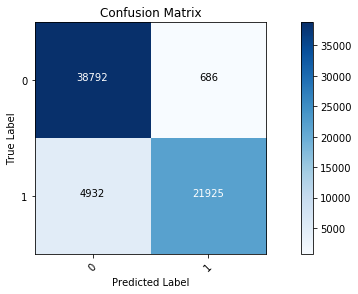

             precision    recall  f1-score   support

          0       0.89      0.98      0.93     39478
          1       0.97      0.82      0.89     26857

avg / total       0.92      0.92      0.91     66335



In [22]:
# define the confusion matrix and plot it using the defined plot_confusion_matrix above
cm = confusion_matrix(y_test, y_pred)
cm_labels = list(set(labels))
plt.figure(figsize=(10,4))
plotConfusionMatrix(cm = cm, classes = cm_labels)
print(classification_report(y_test,y_pred))

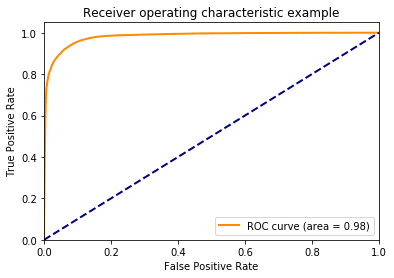

In [23]:
y_score = clf.decision_function(X_test) #Let's find the confidence scores of each campaign being successful. This will be useful for the ROC plot
# compute roc_auc and plot it
plotRocCurve(y_score)


In [18]:
# fit a random forest
model_rfc = RandomForestClassifier()
clf2 = model_rfc.fit(X_train,y_train)
y_pred_2= clf2.predict(X_test)
score2 = accuracy_score(y_test, y_pred_2)
print ('Accuracy for a random forest model is: ',score2*100)

Accuracy for a random forest model is:  99.99698500037687


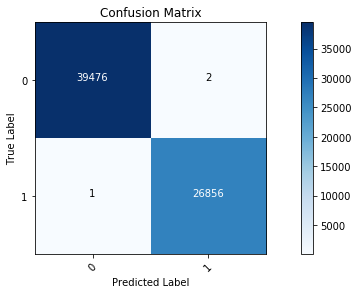

             precision    recall  f1-score   support

          0       1.00      1.00      1.00     39478
          1       1.00      1.00      1.00     26857

avg / total       1.00      1.00      1.00     66335



In [25]:
cm2 = confusion_matrix(y_test, y_pred_2)
plt.figure(figsize=(10,4))
plotConfusionMatrix(cm = cm2, classes = cm_labels)
print(classification_report(y_test,y_pred_2))

Much better! As you see the number of misclassified points have decreased to only 3 points!!

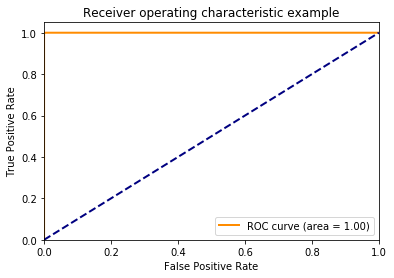

In [26]:
y_score2 = clf2.predict_proba(X_test)
plotRocCurve(y_score2[:,1])

In [28]:
#fit and transform the training data
model_gbc = GradientBoostingClassifier()
clf3 = model_gbc.fit(X_train,y_train)
y_pred_3= clf3.predict(X_test)
score3 = accuracy_score(y_test,y_pred_3)
print ('Accuracy for a gradient boosting model is: ',score3*100)

Accuracy for a gradient boosting model is:  99.99397000075375


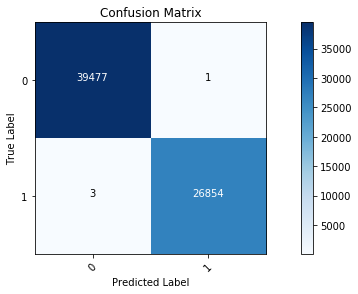

             precision    recall  f1-score   support

          0       1.00      1.00      1.00     39478
          1       1.00      1.00      1.00     26857

avg / total       1.00      1.00      1.00     66335



In [29]:
cm3 = confusion_matrix(y_test, y_pred_3)
plt.figure(figsize=(10,4))
plotConfusionMatrix(cm = cm3, classes = cm_labels)
print(classification_report(y_test,y_pred_3))

XGBoost is doing as well as random forest except that there is and additional misclassified point. 

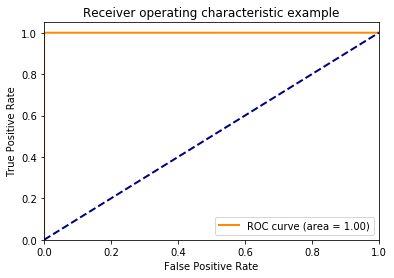

In [30]:
y_score3 = clf3.predict_proba(X_test)
plotRocCurve(y_score3[:,1])

Wonderful! We also tried implementing neural nets but did not gain as good results. The main reason could be relatively small number of inputs that a NN needs to learn from. Since the performance wasn't as good (~ 60 %) we have not included it in this notebook.
We just stick to the random forest model which has so far been our best model. 

****Feature Selection****

Now let's take a further look at what features are most important in deciding the success rate of a campaign as it will affect are decision on how to launch ours afterall. For this matter we are going to implement feature importance to see which features were critical in designing the decision trees. 

**Feature Importance**


Let’s start with decision trees to build some intuition. In decision trees, every node is a condition how to split values in a single feature, so that similar values of dependent variable end up in the same set after the split. The condition is based on impurity, which in case of classification problems is Gini impurity / information gain (entropy), while for regression trees its variance. So when training a tree we can compute how much each feature contributes to decreasing the weighted impurity. feature_importances_ in Scikit-Learn is based on that logic, but in case of Random Forest we are talking about averaging the decrease in impurity over trees.(from https://towardsdatascience.com/explaining-feature-importance-by-example-of-a-random-forest-d9166011959e) 
Let's impement it and find the most important features. 

In [19]:
importances = clf2.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf2.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(df[features].shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))


Feature ranking:
1. feature 27 (0.389265)
2. feature 7 (0.193923)
3. feature 4 (0.098643)
4. feature 6 (0.098316)
5. feature 5 (0.050527)
6. feature 8 (0.049730)
7. feature 28 (0.040532)
8. feature 26 (0.034692)
9. feature 3 (0.034501)
10. feature 25 (0.003353)
11. feature 20 (0.001922)
12. feature 10 (0.001399)
13. feature 23 (0.001255)
14. feature 22 (0.000319)
15. feature 21 (0.000228)
16. feature 1 (0.000183)
17. feature 0 (0.000164)
18. feature 2 (0.000161)
19. feature 24 (0.000153)
20. feature 15 (0.000144)
21. feature 29 (0.000137)
22. feature 11 (0.000125)
23. feature 9 (0.000112)
24. feature 16 (0.000078)
25. feature 17 (0.000074)
26. feature 18 (0.000051)
27. feature 19 (0.000011)
28. feature 14 (0.000003)
29. feature 12 (0.000000)
30. feature 13 (0.000000)


Now it will be easier if we can see what these top features actually are:

In [33]:
#plot the features based on importance rank 
init_notebook_mode(connected=True)
feature_importances = pd.DataFrame(clf2.feature_importances_, index = X_train.columns, columns=['importance'])
feature_importances = feature_importances.sort_values('importance', ascending=False)

colors = ["red"] * 9 + ["green"]*6
trace1 = go.Bar(y = [x.title()+"  " for x in feature_importances.index[:15][::-1]], 
                x = feature_importances.importance[:15][::-1], 
                name="feature importance (relative)",
                marker=dict(color=colors, opacity=0.4), orientation = "h")

data = [trace1]

layout = go.Layout(
    margin=dict(l=400), width = 1000,
    xaxis=dict(range=(0.0,0.15)),
    title=' Feature Importance',
    barmode='group',
    bargap=0.25
)
fig = go.Figure(data=data, layout=layout)
iplot(fig)

It looks like features such as duration, country, name_vowel_ratio, etc, do not play a crucial role in decision making. Let's verify this by dropping these columns and only keeping the so called *important* features.  This will reduce the number of the features to half. 

In [20]:
copy_df = df.copy()
df_imp = copy_df.drop(["category", "main_category", "num_syllable", "num_words", "num_chars", "has_exclaimation_mark", "has_question_mark", "name_is_upper", "name_vowel_ratio", 
                       'launched_month', 'launched_week', 'launched_day', 'is_weekend','duration_in_days', 'country_is_us'], axis = 1) #drop the unnecassary columns

In [21]:
df_imp.columns  #important columns

Index(['ID', 'goal', 'pledged', 'state', 'backers', 'usd pledged',
       'usd_pledged_real', 'usd_goal_real', 'category_goal_mean',
       'category_count', 'main_category_goal_mean', 'main_category_count',
       'diff_mean_category_goal', 'goal_log', 'goal_reached',
       'pledge_per_backer'],
      dtype='object')

In [22]:
#spliting the sub data set into train and test. Same as before
features_imp = [c for c in df_imp.columns if c not in ["state"]]
X_train_imp, X_test_imp, y_train_imp, y_test_imp = train_test_split(df_imp[features_imp], labels, test_size = 0.2, random_state = 2)

In [23]:
# fit a random forest
model_rfc_imp = RandomForestClassifier()
clf_imp = model_rfc_imp.fit(X_train_imp,y_train_imp)
y_pred_imp= clf_imp.predict(X_test_imp)
score_imp = accuracy_score(y_test_imp, y_pred_imp)
print ('Accuracy for a random forest model is: ',score_imp*100)

Accuracy for a random forest model is:  99.99397000075375


**Statistical Tests**


Okay! Looks like the selected features are in fact the decision makers. As the final step to make sure things are not occuring by chance! let's run a statistical test and compare this model with important features with the original one. We will use the mcnemer test as shown below:

In [39]:
import numpy as np
from mlxtend.evaluate import mcnemar_table
from statsmodels.stats.contingency_tables import mcnemar
import statistics

We have defined the function below using the mcnemer package to perform a statistical test for us.

In [40]:
def mcnemerTest(y_model1, y_model2, y_target = y_test):
    """This function constructs a contingency table for two models and computes the p_value to verify if they make the same mistakes or not. i.e. are they statistically 
    different(pvalue < .05) or not(pvalue > .05)
    inputs: 
        y_target: true labels
        y_model1: predictions of model 1
        y_model2: predictions of model 2
    output: 
        statistic: calculated test statistic
        pvalue
    """
    tb = mcnemar_table(y_target, 
                       y_model1, 
                       y_model2)
    result = mcnemar(tb, exact=True)
    return result, tb

In [41]:
result, _ = mcnemerTest(y_pred_2, y_pred_imp)
print(result)

pvalue      1.0
statistic   0.0


As you see these two models are not different from one another! So we can drop the unimortant features with no fear!
Now just to see what will happen if we keep the unimportant features. 

In [42]:
#Let's see how the model performs if we only keep to unimportant features
copy2_df = df.copy()
df_unimp = copy2_df.drop(['ID', 'goal', 'pledged', 'backers', 'usd pledged',
       'usd_pledged_real', 'usd_goal_real', 'category_goal_mean',
       'category_count', 'main_category_goal_mean', 'main_category_count',
       'diff_mean_category_goal', 'goal_log', 'goal_reached',
       'pledge_per_backer'], axis = 1)
features_unimp = [c for c in df_unimp if c not in ['state']]
X_train_unimp, X_test_unimp, y_train_unimp, y_test_unimp = train_test_split(df_unimp[features_unimp], labels, test_size = 0.2, random_state = 2)

In [43]:
# fit a random forest
model_rfc_unimp = RandomForestClassifier()
clf_unimp = model_rfc_unimp.fit(X_train_unimp,y_train_unimp)
y_pred_unimp= clf_unimp.predict(X_test_unimp)
score_unimp = accuracy_score(y_test_unimp, y_pred_unimp)
print ('Accuracy for a random forest model is: ',score_unimp*100)

Accuracy for a random forest model is:  62.36375970453004


Well this was expected. Just to make sure that this not so good model is significantly different from the model with important features, we will run the mcnemer test. 

In [44]:
result, table = mcnemerTest(y_pred_imp, y_pred_unimp)
print(result)

pvalue      0.0
statistic   3.0


Significantly different. This is also verified by printing the contingency table. As shown below the ratio of the two models is 24777:1 !

In [45]:
print(table)

[[41366     3]
 [24966     0]]


**Now how should we launch our campign based on this?**

Very good question! So we have ran a number of analysis and since our model is almost 100% accuract we can derive conclusions about a proposed campaign with high confidence!
Our exploratory data analysis (refer to the R code) suggests that a safe range for this type of campaign could be 120,000 USD with expected pledge of 155000 USD. Base on this and other findings of our EDA we consider a test data point and compute the model's confidence of it being successful. 


Resources: 

* https://www.kaggle.com/shivamb/an-insightful-story-of-crowdfunding-projects
* https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html
* https://www.kaggle.com/srishti280992/kickstarter-project-classification-lgbm-70-3
* https://www.kaggle.com/dronqo/how-successful-is-your-kickstarter-project
* https://www.kaggle.com/kromel/kickstarter-successful-vs-failed
* https://www.kaggle.com/carlolepelaars/exploration-of-kickstarter-data-2010-2017
* https://machinelearningmastery.com/mcnemars-test-for-machine-learning/
* https://www.kaggle.com/dronqo/how-successful-is-your-kickstarter-project